In [1]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import logging

In [73]:
from pandas import IndexSlice as idx

In [2]:
from backtesting import perform_backtest, PortfolioBacktest

In [3]:
source_folder = 'files'

# Reading data

## VFINX

In [4]:
with open(f'{source_folder}/VFINX.json', 'r') as file:
    _vfinx = json.load(file)

vfinx = pd.DataFrame.from_dict(_vfinx).copy()
vfinx.index = pd.Series(pd.to_numeric(vfinx.index)).apply(lambda _date: datetime.fromtimestamp(_date * 1e-3))
vfinx.sort_index(ascending=True, inplace=True)

vfinx.index = vfinx.index.tz_localize(None).floor(freq='D')

In [5]:
vfinx.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,VIX_Close
count,8833.000000,8833.000000,8833.000000,8833.000000,8833.0,8833.000000,8833.0,8833.000000
mean,91.410905,91.410905,91.410905,91.410905,0.0,0.008916,0.0,19.925365
std,74.364430,74.364430,74.364430,74.364430,0.0,0.081741,0.0,8.501164
min,9.693998,9.693998,9.693998,9.693998,0.0,0.000000,0.0,9.140000
25%,26.499744,26.499744,26.499744,26.499744,0.0,0.000000,0.0,14.090000
50%,77.715508,77.715508,77.715508,77.715508,0.0,0.000000,0.0,18.130000
75%,107.777855,107.777855,107.777855,107.777855,0.0,0.000000,0.0,23.250000
max,355.809998,355.809998,355.809998,355.809998,0.0,1.390000,0.0,150.190000


In [6]:
vfinx['Volume'].value_counts()

0    8833
Name: Volume, dtype: int64

In [7]:
vfinx['Dividends'].value_counts()

0.000    8692
0.180      15
0.220      12
0.350       5
0.300       5
         ... 
0.520       1
0.480       1
0.490       1
0.530       1
1.311       1
Name: Dividends, Length: 91, dtype: int64

In [8]:
vfinx['Stock Splits'].value_counts()

0    8833
Name: Stock Splits, dtype: int64

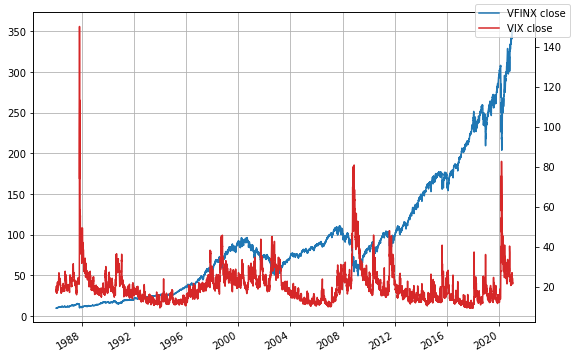

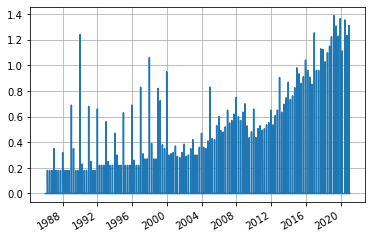

In [9]:
fig, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()

vfinx['Close'].plot(ax=ax1, label='VFINX close')
vfinx['VIX_Close'].plot(ax=ax2, label='VIX close', color='tab:red')

fig.legend()
ax1.grid()
# ax2.grid()
fig.tight_layout()
plt.show()

vfinx['Dividends'].plot()
plt.grid()
plt.show()

## 10Y US Notes

In [10]:
ust = pd.read_csv('files/ust_10y_yields_hist.csv')
ust['Date'] = pd.to_datetime(ust['Date'])
ust.set_index('Date', inplace=True)
ust.sort_index(ascending=True, inplace=True)

In [11]:
ust['Close'].describe()

count    9061.000000
mean        4.727160
std         2.321428
min         0.499000
25%         2.624000
50%         4.564000
75%         6.537000
max        10.230000
Name: Close, dtype: float64

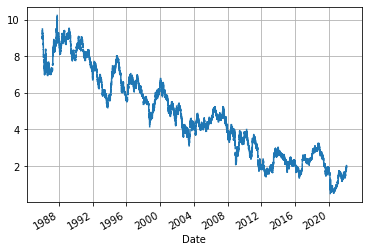

In [12]:
ust['Close'].plot()

plt.grid()
plt.show()

# Strategy

# Backtesting

In [48]:
# logging.basicConfig(level=logging.DEBUG)

In [49]:
annualization_factor = 360

portf_res = perform_backtest(vfinx['Close'], ust['Close'] / 100, risk_free_annualized=True,
                             annualization_factor=annualization_factor).copy()

DEBUG:backtesting.perform_backtest:Date
1986-01-02    0.09040
1986-01-03    0.09050
1986-01-05        NaN
1986-01-06    0.09070
1986-01-07    0.08940
               ...   
2022-02-07    0.01916
2022-02-08    0.01954
2022-02-09    0.01929
2022-02-10    0.02031
2022-02-11    0.01955
Name: risk free rate, Length: 11172, dtype: float64


In [50]:
portf_res.describe()

,value,daily return,daily return ann,total return,risk free rate,risk free rate daily,excess return,excess return daily,daily PnL,total PnL
count,8833.000000,8832.000000,8.832000e+03,8832.000000,8790.000000,8790.000000,8.789000e+03,8789.000000,8832.000000,8832.000000
mean,91.410905,0.000473,1.618463e+13,8.170011,0.048241,0.000130,1.626382e+13,0.000338,0.039037,81.450659
std,74.364430,0.011688,1.408506e+15,7.459134,0.022859,0.000060,1.411947e+15,0.011706,1.376222,74.363590
min,9.693998,-0.204649,-1.000000e+00,-0.027631,0.004990,0.000014,-1.102300e+00,-0.204918,-29.584320,-0.275469
25%,26.499744,-0.004183,-7.788449e-01,1.658446,0.027502,0.000075,-8.303978e-01,-0.004329,-0.243201,16.533826
50%,77.715508,0.000691,2.821215e-01,6.796972,0.046400,0.000126,2.292074e-01,0.000553,0.029929,67.762188
75%,107.777855,0.005736,6.838076e+00,9.812802,0.065890,0.000177,6.788792e+00,0.005604,0.370338,97.828411
max,355.809998,0.115723,1.319313e+17,34.689971,0.102300,0.000271,1.319313e+17,0.115618,21.052658,345.840530


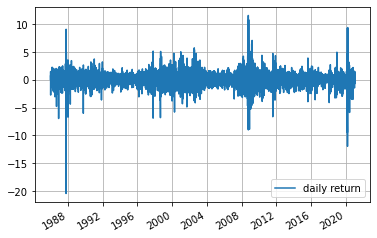

In [51]:
_cols = ['daily return']
_data = portf_res[_cols] * 100
_data.plot()

plt.grid()
plt.show()

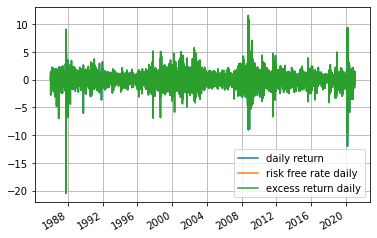

In [52]:
_cols = ['daily return', 'risk free rate daily', 'excess return daily']
_data = portf_res[_cols] * 100
_data.plot()

plt.grid()
plt.show()

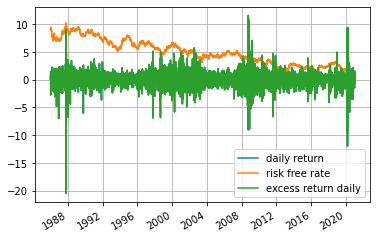

In [53]:
_cols = ['daily return', 'risk free rate', 'excess return daily']
_data = portf_res[_cols] * 100
_data.plot()

plt.grid()
plt.show()

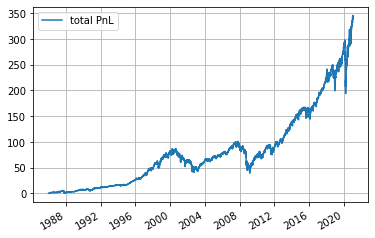

In [54]:
_cols = ['total PnL']
_data = portf_res[_cols]
_data.plot()

plt.grid()
plt.show()

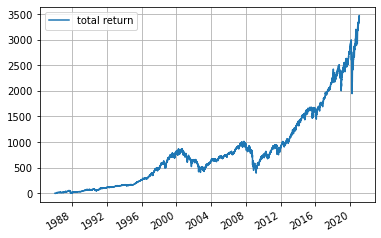

In [55]:
_cols = ['total return']
_data = portf_res[_cols] * 100
_data.plot()

plt.grid()
plt.show()

## Buy and hodl CAGR

In [56]:
(portf_res['total return'].iloc[-1] + 1) ** (1 / 35) - 1

0.10744225828819376

## Sharpe

In [57]:
portf_res['excess return'].mean() / portf_res['excess return'].std()

0.011518717683548022

In [58]:
portf_res['excess return daily'].mean() / portf_res['excess return daily'].std()

0.02888785870970048

# Testing if my backtester works properly on a small artificial sample

In [93]:
portfolio = pd.read_excel(f'{source_folder}/test_portfolio.xlsx', index_col=[0, 1])
portfolio['rebalance'].replace(np.nan, 0, inplace=True)

# secs = portfolio.index.get_level_values('sec').unique().values
secs = ['VFINX']

In [94]:
portfolio = portfolio.unstack(level='sec').copy()

In [16]:
dates = portfolio.index

quotes = portfolio.xs('price', axis='columns', level=0).copy()

allocation = portfolio.xs('weight', axis='columns', level=0).copy()

positions = portfolio.xs('#', axis='columns', level=0).copy()

positions_values = portfolio.xs('value', axis='columns', level=0).copy()


_combined = {'price': quotes, 'weight': allocation, '#': positions, 'value': positions_values}

In [17]:
nav = pd.Series(index=dates, dtype=float, name='NAV')

capital = 1e2
nav.iloc[0] = capital

In [18]:
_p = pd.concat(_combined, axis='columns', join='outer')

_p.columns.names = ['attr', 'sec']

_p['nav'] = nav

_p.iloc[1:] = np.nan

In [19]:
_p

attr       price      weight          #       value          nav
sec        VFINX cash  VFINX cash VFINX  cash VFINX  cash       
date                                                            
2020-02-01  10.0  1.0    0.5  0.5   5.0  50.0  50.0  50.0  100.0
2020-02-02   NaN  NaN    NaN  NaN   NaN   NaN   NaN   NaN    NaN
2020-02-03   NaN  NaN    NaN  NaN   NaN   NaN   NaN   NaN    NaN

In [20]:
exog = pd.DataFrame([0, 1, 0], index=dates, columns=['flag'])

In [21]:
exog

,flag
date,
2020-02-01,0
2020-02-02,1
2020-02-03,0


In [22]:
quotes[secs]

sec,VFINX
date,
2020-02-01,10
2020-02-02,11
2020-02-03,12


In [23]:
logging.basicConfig(level=logging.DEBUG)

In [24]:
ini_positions = pd.Series({'VFINX': 5, 'cash': 50})

In [25]:
pb = PortfolioBacktest(securities=secs,
                       dates=dates,
                       quotes=quotes[secs],
                       capital=capital,
                       ini_positions=ini_positions,
                       max_loan=0)

INFO:PortfolioBacktesting:Creating an instance of PortfolioBacktesting
DEBUG:PortfolioBacktesting:quotes:
sec         VFINX  cash
date                   
2020-02-01     10     1
2020-02-02     11     1
2020-02-03     12     1
DEBUG:PortfolioBacktesting:rebalance_prices:
            VFINX  cash
date                   
2020-02-01    NaN     1
2020-02-02    NaN     1
2020-02-03    NaN     1
DEBUG:PortfolioBacktesting:positions:
            VFINX  cash
date                   
2020-02-01    5.0  50.0
2020-02-02    NaN   NaN
2020-02-03    NaN   NaN
DEBUG:PortfolioBacktesting:positions_values:
            VFINX  cash
date                   
2020-02-01   50.0  50.0
2020-02-02    NaN   NaN
2020-02-03    NaN   NaN
DEBUG:PortfolioBacktesting:nav:
date
2020-02-01    100.0
2020-02-02      NaN
2020-02-03      NaN
Name: NAV, dtype: float64
DEBUG:PortfolioBacktesting:allocation:
            VFINX  cash
date                   
2020-02-01    0.5   0.5
2020-02-02    NaN   NaN
2020-02-03    NaN   NaN


In [26]:
pb.apply_strategy(exogenous=exog['flag'])

INFO:PortfolioBacktesting:Starting rebalance procedure. Date: 2020-02-02 00:00:00, next date: 2020-02-03 00:00:00, positions_change: {'VFINX': -1}, rebalance_prices:
sec
VFINX    12
cash      1
Name: 2020-02-03 00:00:00, dtype: int64
DEBUG:PortfolioBacktesting:positions_change.loc['cash']: 12.0
DEBUG:PortfolioBacktesting:value_change:
VFINX   -12.0
cash     12.0
dtype: float64
DEBUG:PortfolioBacktesting:positions_next:
VFINX     4.0
cash     62.0
dtype: float64
DEBUG:PortfolioBacktesting:positions_values_next:
VFINX    48.0
cash     62.0
dtype: float64
DEBUG:PortfolioBacktesting:nav_next: 110.0
DEBUG:PortfolioBacktesting:allocation_next:
VFINX    0.436364
cash     0.563636
dtype: float64
INFO:PortfolioBacktesting:Rebalance is possible? - True
INFO:PortfolioBacktesting:Rebalance successfully completed


In [27]:
pb.get_combined_df()

attr       price         weight               #       value        \
sec        VFINX cash     VFINX      cash VFINX  cash VFINX  cash   
date                                                                
2020-02-01    10    1  0.500000  0.500000   5.0  50.0  50.0  50.0   
2020-02-02    11    1  0.523810  0.476190   5.0  50.0  55.0  50.0   
2020-02-03    12    1  0.436364  0.563636   4.0  62.0  48.0  62.0   

attr       rebalance price         nav  
sec                  VFINX cash         
date                                    
2020-02-01             NaN    1  100.0  
2020-02-02             NaN    1  105.0  
2020-02-03            12.0    1  110.0

In [95]:
portfolio

price         weight               #      value      rebalance  \
sec        VFINX cash     VFINX      cash VFINX cash VFINX cash     VFINX   
date                                                                        
2020-02-01    10    1  0.500000  0.500000     5   50    50   50       0.0   
2020-02-02    11    1  0.523810  0.476190     5   50    55   50       0.0   
2020-02-03    12    1  0.436364  0.563636     4   62    48   62      -1.0   

                 rebalance price       total       
sec         cash           VFINX cash  VFINX cash  
date                                               
2020-02-01   0.0             NaN  1.0  100.0  NaN  
2020-02-02   0.0             NaN  1.0  105.0  NaN  
2020-02-03  12.0            12.0  1.0  110.0  NaN

In [99]:
res = pb.get_combined_df().copy()
my_res = res[res.columns[res.columns.get_level_values(0) != 'nav']].copy()
test_portf = portfolio.loc[:, idx[(portfolio.columns.get_level_values(0) != 'total') & \
                                  (portfolio.columns.get_level_values(0) != 'rebalance'), :]].copy()

_tol = 1e-10
(abs(my_res.replace(np.nan, 0) - test_portf.replace(np.nan, 0)) < _tol).all()

attr             sec  
price            VFINX    True
                 cash     True
weight           VFINX    True
                 cash     True
#                VFINX    True
                 cash     True
value            VFINX    True
                 cash     True
rebalance price  VFINX    True
                 cash     True
dtype: bool